In [1]:
import json
import torch

def process_data(filename):
   """Combines the functionality of three functions to process data from a JSON file.

   Args:
       filename: The name of the JSON file to process.

   Returns:
       A tuple containing a PyTorch tensor of vectors and a list of converted smiles.
   """

   with open(filename, "r") as f:
       data = json.load(f)

   vector_list = []
   smiles_list = []
   for item in data:
       vector_list.append(item["vector"])
       smiles_list.append(item["smiles"])

   vector_tensor = torch.tensor(vector_list)
   vector_tensor = vector_tensor.view(-1, vector_tensor[0].shape[-1])
   smiles_one_hot = [1 if smiles[0] is not None else 0 for smiles in smiles_list]

   return vector_tensor, smiles_one_hot

# Example usage
filename = "/home/chenyo/OW_DOE/Algorithms/CON_BO/vae_con_neg_x/x_y.json"
x, y = process_data(filename)

In [2]:
indices = [i for i, val in enumerate(y) if val == 1]
valid_x = x[indices]

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 將 valid_x 改為一維
valid_x_flattened = valid_x.view(-1)

# 計算平均值和標準差
mean = torch.mean(valid_x_flattened).item()
std = torch.std(valid_x_flattened).item()
print('mean:', mean)
print('std:', std)

mean: -0.004060143604874611
std: 5.431295871734619


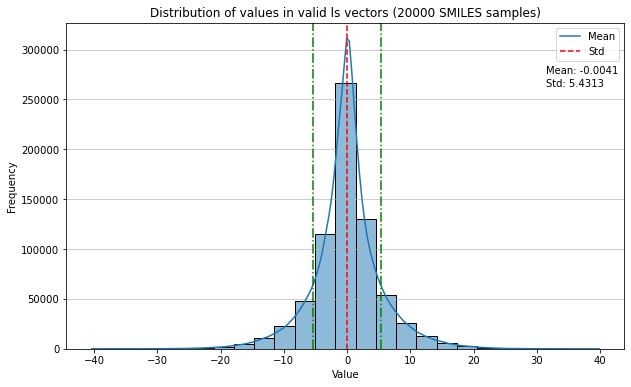

In [6]:
# 繪製直方圖
plt.figure(figsize=(10, 6))
sns.histplot(valid_x_flattened.numpy(), bins=25, kde=True)
plt.axvline(mean, color='r', linestyle='--')
plt.axvline(mean + std, color='g', linestyle='-.')
plt.axvline(mean - std, color='g', linestyle='-.')

# 在左上角添加平均值和標準差
plt.text(0.86, 0.87, f'Mean: {mean:.4f}', ha='left', va='top', transform=plt.gca().transAxes)
plt.text(0.86, 0.83, f'Std: {std:.4f}', ha='left', va='top', transform=plt.gca().transAxes)

plt.legend({'Mean':mean,'Std':std})
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of values in valid ls vectors (20000 SMILES samples)')
plt.show()

In [5]:
import torch

# 95% 信賴區間
confidence_intervals = torch.tensor([[176.1946, 0.5665],
                        [161.6851, 0.4246],
                        [189.9218, 1.0923],
                        [169.0334, 0.7438],
                        [1.0, 0.0]])

# 計算標準差
std_devs = (confidence_intervals[:, 0]- confidence_intervals[:, 1]) / (2 * 1.96)

print(std_devs)

tensor([44.8031, 41.1379, 48.1708, 42.9310,  0.2551])


In [8]:
tensor = torch.full((32,), 5.431295871734619)

print(tensor)

tensor([5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313,
        5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313,
        5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313, 5.4313,
        5.4313, 5.4313, 5.4313, 5.4313, 5.4313])


In [9]:
std_tensor = torch.cat((tensor, std_devs))
std_tensor

tensor([ 5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,
         5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,
         5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,
         5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,  5.4313,
        44.8031, 41.1379, 48.1708, 42.9310,  0.2551])

In [24]:
import pandas as pd

bounds =pd.read_csv('bounds.csv')
print(bounds)

  column_name  upper_bound  lower_bound  dimension  continuous
0   ls_vector       5.0000      -5.0000         32           1
1   Reagent_1     179.1946       0.5665          1           1
2   Reagent_2     161.6851       0.4246          1           1
3   Reagent_3     189.9218       1.0923          1           1
4   Reagent_4     169.0334       0.7438          1           1
5    lab_code       1.0000       0.0000          1           0


In [49]:
import torch
import numpy as np

# Get the values of the 'upper_bound', 'lower_bound' and 'dimension' columns
upper_bounds = bounds['upper_bound'].values
lower_bounds = bounds['lower_bound'].values
dimensions = bounds['dimension'].values

# Get the rows where 'dimension' is not 'ls_vector'
mask = (bounds['column_name'] != 'ls_vector') & (bounds['continuous'] == 1)
print(mask)

# Get the values of the 'upper_bound', 'lower_bound' and 'dimension' columns
if True:
    upper_bounds = np.where(mask, np.log(upper_bounds), upper_bounds)
    lower_bounds = np.where(mask, np.log(lower_bounds), lower_bounds)

# Initialize an empty list for the bounds
lower_bounds_list = []
upper_bounds_list = []

# Iterate over the bounds and dimensions
for ub, lb, dim in zip(upper_bounds, lower_bounds, dimensions):
    # Repeat the upper and lower bounds according to the dimension and append to the list
    lower_bounds_list.extend([lb]*dim)
    upper_bounds_list.extend([ub]*dim)

# Convert the list to a tensor
lower_bounds_tensor = torch.tensor(lower_bounds_list)
upper_bounds_tensor = torch.tensor(upper_bounds_list)

# Stack the tensors to have 2 rows
bounds_tensor = torch.stack((upper_bounds_tensor, lower_bounds_tensor))

print(bounds_tensor)

0    False
1     True
2     True
3     True
4     True
5    False
dtype: bool
tensor([[ 5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,
          5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,
          5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,
          5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,  5.0000,
          5.1885,  5.0857,  5.2466,  5.1301,  1.0000],
        [-5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
         -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
         -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
         -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000, -5.0000,
         -0.5683, -0.8566,  0.0883, -0.2960,  0.0000]], dtype=torch.float64)


<ipython-input-49-d703f9ec845b>:16: RuntimeWarning: divide by zero encountered in log
  lower_bounds = np.where(mask, np.log(lower_bounds), lower_bounds)
<ipython-input-49-d703f9ec845b>:16: RuntimeWarning: invalid value encountered in log
  lower_bounds = np.where(mask, np.log(lower_bounds), lower_bounds)
